### 2023-05-30 coarsened-fine cloud and radiation fields

Make representative plots of coarsened-fine cloud and radiation fields, using the 10-day PIRE-like reference.

In [1]:
import xarray as xr
import numpy as np
import cftime
import dataclasses
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from cartopy import crs as ccrs
import fv3viz
from vcm.interpolate import interpolate_unstructured, interpolate_to_pressure_levels
from vcm.select import meridional_ring
from vcm.fv3.metadata import standardize_fv3_diagnostics
from vcm.catalog import catalog as CATALOG

In [2]:
C48_REFERENCE_KEY = '10day_c48_PIRE_ccnorm_gfsphysics_15min_may2023'
COARSENED_FINE_PATH = 'gs://vcm-ml-experiments/cloud-ml/2023-07-04/cloud-ml-training-data.zarr'
COARSENED_FINE_VARIABLES = [
    'cloud_amount',
    'cloud_ice_mixing_ratio',
    'cloud_water_mixing_ratio',
]
TIME_SNAPSHOT = cftime.DatetimeJulian(2020, 8, 7, 10, 30, 0, 0)
TRANSECT_LON_DEG = 60
GRID = CATALOG['grid/c48'].read()
OUTDIR = 'figures'
plt.rcParams.update({'font.size': 8})

In [3]:
@dataclasses.dataclass
class RadiationDiag:
    fortran_diag_name: str
    python_diag_name: str
    scale: float
    
FLUXES = [
    RadiationDiag('DSWRFtoa', 'total_sky_downward_shortwave_flux_at_top_of_atmosphere', 2.0),
    RadiationDiag('DCSWRFsfc', 'clear_sky_downward_shortwave_flux_at_surface', 2.0),
    RadiationDiag('UCSWRFsfc', 'clear_sky_upward_shortwave_flux_at_surface', 2.0),
    RadiationDiag('UCSWRFtoa', 'clear_sky_upward_shortwave_flux_at_top_of_atmosphere', 2.0),
    RadiationDiag('DCLWRFsfc', 'clear_sky_downward_longwave_flux_at_surface', 2.0),
    RadiationDiag('UCLWRFsfc', 'clear_sky_upward_longwave_flux_at_surface', 2.0),
    RadiationDiag('UCLWRFtoa', 'clear_sky_upward_longwave_flux_at_top_of_atmosphere', 2.0),
    RadiationDiag('DSWRFsfc', 'total_sky_downward_shortwave_flux_at_surface', 100.0),
    RadiationDiag('USWRFsfc', 'total_sky_upward_shortwave_flux_at_surface', 100.0),
    RadiationDiag('USWRFtoa', 'total_sky_upward_shortwave_flux_at_top_of_atmosphere', 100.0),
    RadiationDiag('DLWRFsfc', 'total_sky_downward_longwave_flux_at_surface', 30.0),
    RadiationDiag('ULWRFsfc', 'total_sky_upward_longwave_flux_at_surface', 30.0),
    RadiationDiag('ULWRFtoa', 'total_sky_upward_longwave_flux_at_top_of_atmosphere', 30.0)
]

In [4]:
def get_coarsened_fine_clouds():
    coarsened_fine_clouds = (
        xr.open_zarr(COARSENED_FINE_PATH, consolidated=True)[COARSENED_FINE_VARIABLES]
    )
    return coarsened_fine_clouds

def add_cloud_condensate(cloud_ice_mixing_ratio, cloud_water_mixing_ratio):
    cloud_condensate_mixing_ratio = cloud_ice_mixing_ratio + cloud_water_mixing_ratio
    return cloud_condensate_mixing_ratio.assign_attrs(
        {'long_name': 'cloud condensate mixing ratio', 'units': 'kg/kg'}
    )


def add_cloud_amount_attrs(cloud_amount):
    return cloud_amount.assign_attrs(
        {'long_name': 'fractional cloud cover', 'units': '-'}
    )

def get_coarsened_fine_fluxes():
    ds = CATALOG[C48_REFERENCE_KEY].to_dask()
    ds = _rename_fortran_fluxes(ds)
    return ds

def _rename_fortran_fluxes(ds):
    ds = standardize_fv3_diagnostics(ds)
    ds_rename = xr.Dataset()
    for diag in FLUXES:
        if diag.fortran_diag_name in ds:
            ds_rename[diag.python_diag_name] = ds[diag.fortran_diag_name]
    return ds_rename

def plot_map(field_var, ax, panel_label, weights=GRID.area, **plot_kube_kwargs):
    plot_kube_kwargs.update({'cbar_label': '$W/{m^2}$'})
    fv3viz.plot_cube(xr.merge([field_var, GRID]), field_var.name, ax=ax, rasterized=True, **plot_kube_kwargs)
    mean = weighted_mean(field_var, weights)
    stdev = weighted_stdev(field_var - mean, weights)
    title = field_var.attrs['long_name'].split(' [')[0]
    ax.set_title(f"{panel_label} {title}\nmean: {int(mean.item()):d}, st. dev.: {int(stdev.item()):d}")
    
def plot_transect(da, ax, scale, cmap='RdBu_r'):
    hm = da.plot(
        vmin=scale[0],
        vmax=scale[1],
        yincrease=False,
        cmap=cmap,
        ax=ax,
        add_colorbar=False,
        rasterized=True
    )
    ticks = np.linspace(int(scale[0]), int(scale[1]), int(scale[1] - scale[0]) + 1)
    ticklabels = [f"{10**i:{abs(int(i))}.{abs(int(i))}f}" for i in ticks]
    cbar = plt.gcf().colorbar(hm, ax=ax, label=da.attrs["units"], ticks=ticks)
    cbar.ax.set_yticklabels(ticklabels)
    ax.grid()
    ax.set_ylabel('pressure [hPa]')
    ax.set_xlabel('latitude $[\circ]$')

def log_ds(ds, log_func=np.log10):
    log = xr.Dataset()
    for var in ds.data_vars:
        log[var] = log_func(ds[var]).assign_attrs({
            'long_name': ds[var].attrs.get('long_name', var),
            'units': ds[var].attrs.get('units', 'unknown'),
        })
    return log

def weighted_mean(da, weights, dims=['x', 'y', 'tile']):
    return da.weighted(weights).mean(dim=dims)

def weighted_stdev(deviations, weights, dims=['x', 'y', 'tile']):
    weighted_squares = (deviations ** 2).weighted(weights).mean(dim=dims)
    return (weighted_squares ** 0.5)

def get_coarsened_fine_delp():
    return xr.open_zarr(COARSENED_FINE_PATH)['pressure_thickness_of_atmospheric_layer']

In [5]:
coarsened_fine_clouds = get_coarsened_fine_clouds()
coarsened_fine_clouds = coarsened_fine_clouds.assign(
        cloud_condensate_mixing_ratio=add_cloud_condensate(
            coarsened_fine_clouds.cloud_ice_mixing_ratio,
            coarsened_fine_clouds.cloud_water_mixing_ratio)
    )
coarsened_fine_clouds = coarsened_fine_clouds.assign(
    cloud_amount = add_cloud_amount_attrs(coarsened_fine_clouds.cloud_amount)
)
coarsened_fine_clouds = coarsened_fine_clouds.sel(time=TIME_SNAPSHOT)
coarsened_fine_delp = get_coarsened_fine_delp().sel(time=TIME_SNAPSHOT)

coarsened_fine_clouds_pressure = interpolate_to_pressure_levels(coarsened_fine_clouds, coarsened_fine_delp, dim='z')
coarsened_fine_clouds_pressure = coarsened_fine_clouds_pressure.assign_coords({
    'pressure': (coarsened_fine_clouds_pressure.pressure / 100)})

meridional_transect = meridional_ring(lon=TRANSECT_LON_DEG)
transect = interpolate_unstructured(
    xr.merge([coarsened_fine_clouds_pressure, GRID.lat, GRID.lon]), meridional_transect
).swap_dims({'sample': 'lat'})
for var in COARSENED_FINE_VARIABLES:
    transect[var] = transect[var].assign_attrs(**coarsened_fine_clouds[var].attrs)

log_transect = log_ds(transect)

with ProgressBar():
    log_transect.load()

[##############################          ] | 75% Completed | 811.37 ms

/home/brianh/miniconda3/envs/fv3net/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/home/brianh/miniconda3/envs/fv3net/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 1.62 sms


In [6]:
coarsened_fine_fluxes = get_coarsened_fine_fluxes()
coarsened_fine_fluxes = coarsened_fine_fluxes.sel(time=coarsened_fine_clouds.time)

with ProgressBar():
    coarsened_fine_fluxes.load()

[########################################] | 100% Completed | 3.65 sms


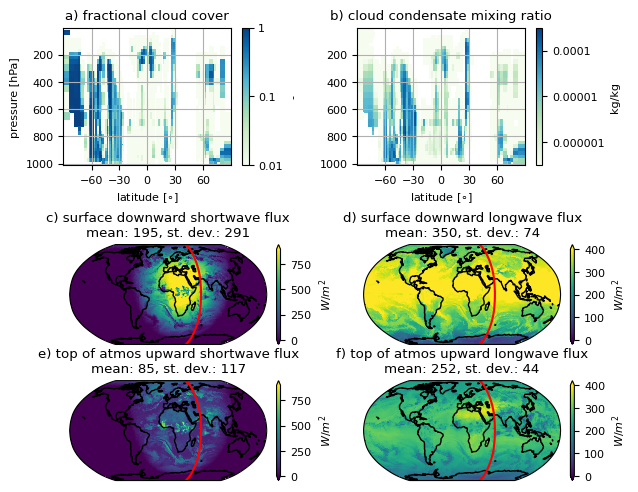

In [7]:
fig = plt.figure()
gs = GridSpec(nrows=4, ncols=2, figure=fig, wspace=0.4, hspace=0.42, height_ratios=[0.4, 0.02, 0.29, 0.29])
ax0 = fig.add_subplot(gs[0, 0])
plot_transect(log_transect.cloud_amount, ax=ax0, scale=(-2, 0), cmap='GnBu')
bbox = ax0.get_position()
ax0.set_position([bbox.x0, bbox.y0, bbox.width, 0.8*bbox.height])
ax0.set_xticks(np.arange(-60, 90, 30))
ax0.set_title(f'a) {log_transect.cloud_amount.attrs["long_name"]}')
ax1 = fig.add_subplot(gs[0, 1])
plot_transect(log_transect.cloud_condensate_mixing_ratio, ax=ax1, scale=(-6.5, -3.5), cmap='GnBu')
ax1.set_ylabel(None)
ax1.set_xticks(np.arange(-60, 90, 30))
ax1.set_title(f'b) {log_transect.cloud_condensate_mixing_ratio.attrs["long_name"]}')
ax2 = fig.add_subplot(gs[2, 0], projection=ccrs.Robinson())
plot_map(
    coarsened_fine_fluxes.total_sky_downward_shortwave_flux_at_surface,
    ax=ax2,
    panel_label='c)',
    vmin=0,
    vmax=900,
)
ax2.plot(
    meridional_transect['lon'],
    meridional_transect['lat'],
    transform=ccrs.PlateCarree(),
    ls='-',
    color='r'
)
ax3 = fig.add_subplot(gs[2, 1], projection=ccrs.Robinson())
plot_map(
    coarsened_fine_fluxes.total_sky_downward_longwave_flux_at_surface,
    ax=ax3,
    panel_label='d)',
    vmin=0,
    vmax=400
)
ax3.plot(
    meridional_transect['lon'],
    meridional_transect['lat'],
    transform=ccrs.PlateCarree(),
    ls='-',
    color='r'
)
ax4 = fig.add_subplot(gs[3, 0], projection=ccrs.Robinson())
plot_map(
    coarsened_fine_fluxes.total_sky_upward_shortwave_flux_at_top_of_atmosphere,
    ax=ax4,
    panel_label='e)',
    vmin=0,
    vmax=900
)
ax4.plot(
    meridional_transect['lon'],
    meridional_transect['lat'],
    transform=ccrs.PlateCarree(),
    ls='-',
    color='r'
)
ax5 = fig.add_subplot(gs[3, 1], projection=ccrs.Robinson())
plot_map(
    coarsened_fine_fluxes.total_sky_upward_longwave_flux_at_top_of_atmosphere,
    ax=ax5,
    panel_label='f)',
    vmin=0,
    vmax=400
)
ax5.plot(
    meridional_transect['lon'],
    meridional_transect['lat'],
    transform=ccrs.PlateCarree(),
    ls='-',
    color='r'
)
fig.set_size_inches([6.5, 6])
fig.set_dpi(100)
fig.savefig(f'./{OUTDIR}/coarsened_fine_cloud_radiation.pdf', bbox_inches='tight')